# 롯데는 정말 우승 할 수 없는거니?

## 필수 라이브러리 임포트

In [1]:
import re
import os
import json

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D
from math import pi

import requests
from bs4 import BeautifulSoup
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

root_path = '/content/drive/MyDrive/Colab Notebooks/kbo/'
# https://drive.google.com/file/d/1T1WxkUTN3z4oJZBy2AwlG-0SMq3CY7Jf/view

## 그래프 한글화 대응

In [2]:
# 실행 후 런다임 재시작 필요
!apt install fonts-nanum-coding
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum-coding is already the newest version (2.5-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 2 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [3]:
for f in fm.get_fontconfig_fonts():
    if 'Nanum' in f:
        print(f)

/usr/share/fonts/truetype/nanum/NanumGothicCoding-Bold.ttf
/usr/share/fonts/truetype/nanum/NanumGothicCoding.ttf


In [4]:
plt.rcParams['figure.figsize'] = (14, 4)
plt.rcParams['font.size'] = 13
font_location = '/usr/share/fonts/truetype/nanum/NanumGothicCoding.ttf'
font_name = fm.FontProperties(fname=font_location).get_name()
plt.rc('font', family=font_name)

## 필수 함수 작성
* 시즌 랭킹, 시즌별 특정 팀 라인업을 크롤링으로 가져온다.(팀 타겟 분석용)
* 방사형 그래프를 그리기 위한 함수 정의

In [5]:
def get_ranking(year=2020):
    "시즌별 랭킹"
    req = requests.get('http://www.statiz.co.kr/league.php?sopt=0', params=dict(opt=year))
    soup = BeautifulSoup(req.text)
    is_find = False
    for box in soup.find_all('div', {'class': 'box'}):
        chk = box.find('div', {'class': 'box-header'})
        if chk and chk.text.strip() == '정규':
            is_find = True
            break

    if not is_find:
        return []

    tbl = box.find('table')
    trs = tbl.find_all('tr')
    ranking = []
    for tr in trs[1:]:
        tds = tr.find_all('td')
        ranking.append(tds[1].text)
        
    return ranking

In [6]:
def get_players(year=2020, team='롯데'):
    "소속팀 선수들 크롤링"
    req = requests.get('http://www.statiz.co.kr/team.php?opt=0&sopt=7', params=dict(year=year, team=team))
    soup = BeautifulSoup(req.text)

    return [x.text for x in soup.find_all('a', href='player.php?name=')]

In [7]:
def get_starting(year=2020, team='롯데'):
    "스타팅 라인업 크롤링(베스트 멤버)"
    req = requests.get('http://www.statiz.co.kr/team.php?opt=0&sopt=3', params=dict(year=year, team=team))
    soup = BeautifulSoup(req.text)

    starting = soup.find_all('div', {'class': 'box-body'})[1]
    return [re.sub(r'[^가-힣]', '', x.text) for x in starting.find_all('a')]

In [8]:
def render_spider_plot2(data1:pd.DataFrame, data2=None, columns=None, ax=None, title='', label=[]):
    "방사형 그래프 그리기"
    if not columns:
        columns = ['타율', '출루율', '장타율', '도루율', '홈런율', 'OPS', 'WAR']

    if not label:
        label = ['비교군', '롯데']

    data1 = data1[columns].mean().reset_index()
    data2 = data2[columns].mean().reset_index()
    spider = pd.DataFrame([list(data1[0]), list(data2[0])], columns=columns)

    N = len(columns)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialize the spider plot
    if not ax:
        ax = plt.subplot(111, polar=True)
    if title:
        ax.set_title(title, size=20)

    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    plt.xticks(angles[:-1], columns, size=11)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks(list(range(25, 76, 25)), list(map(str, range(25, 76, 25))), color='grey', size=10)
    plt.ylim(0, 100)

    # Ind1
    values=spider.loc[0].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=label[0])
    ax.fill(angles, values, 'b', alpha=0.1)

    # Ind2
    values=spider.loc[1].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=label[1])
    ax.fill(angles, values, 'r', alpha=0.1)

    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

In [9]:
def render_spider_plot(data1:pd.DataFrame, data2=None, columns=None, ax=None, title='', label=[]):
    "방사형 그래프 그리기"
    if not columns:
        columns = ['타율', '출루율', '장타율', '도루율', '홈런율', 'OPS', 'WAR']

    if not label:
        label = ['비교군', '롯데']

    data1 = data1[columns].mean().reset_index()
    data2 = data2[columns].mean().reset_index()
    spider = pd.DataFrame([list(data1[0]), list(data2[0])], columns=columns)

    N = len(columns)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialize the spider plot
    if not ax:
        ax = plt.subplot(111, polar=True)
    if title:
        ax.set_title(title, size=20)

    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    plt.xticks(angles[:-1], columns, size=11)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks(list(range(25, 76, 25)), list(map(str, range(25, 76, 25))), color='grey', size=10)
    plt.ylim(0, 100)

    # Ind1
    values=spider.loc[0].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=label[0])
    ax.fill(angles, values, 'b', alpha=0.1)

    # Ind2
    values=spider.loc[1].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=label[1])
    ax.fill(angles, values, 'r', alpha=0.1)

    for g in ax.yaxis.get_gridlines(): ## grid line 
        g.get_path()._interpolation_steps = N
    
    spine = Spine(axes=ax,
            spine_type='circle',
            path=Path.unit_regular_polygon(N))
    
    ## Axes의 중심과 반지름을 맞춰준다.
    spine.set_transform(Affine2D().scale(.5).translate(.5, .5)+ax.transAxes)
            
    ax.spines = {'polar':spine} ## frame의 모양을 원에서 폴리곤으로 바꿔줘야한다.

    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

## 데이터 전처리
* 데이터 로드
* 컬럼 한글화
* 불필요한 컬럼 제거
* 롯데 선수단 파악
* 데이터 정규화

In [10]:
kbo = pd.read_csv(root_path + '2019_kbo_for_kaggle_v2.csv')
kbo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1913 entries, 0 to 1912
Data columns (total 37 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   batter_name  1913 non-null   object 
 1   age          1913 non-null   float64
 2   G            1913 non-null   float64
 3   PA           1913 non-null   float64
 4   AB           1913 non-null   float64
 5   R            1913 non-null   float64
 6   H            1913 non-null   float64
 7   2B           1913 non-null   float64
 8   3B           1913 non-null   float64
 9   HR           1913 non-null   float64
 10  TB           1913 non-null   float64
 11  RBI          1913 non-null   float64
 12  SB           1913 non-null   float64
 13  CS           1913 non-null   float64
 14  BB           1913 non-null   float64
 15  HBP          1913 non-null   float64
 16  GB           1913 non-null   float64
 17  SO           1913 non-null   float64
 18  GDP          1913 non-null   float64
 19  BU    

In [11]:
# 불필요한 컬럼과 미래 예측에 대한 컬럼은 제거
del kbo['cp'], kbo['p_year'], kbo['YAB'], kbo['YOPS']

### 1. 컬럼 한글화

In [12]:
columns_kor = {
    "batter_name": "이름",
    "age": "나이",
    "hand2":"타석",
    "G": "경기수",
    "PA": "타수",
    "AB": "타석수",
    "R": "득점",
    "H": "안타",
    "1B": "1루타",
    "2B": "2루타",
    "3B": "3루타",
    "HR": "홈런",
    "TB": "총루타수",
    "RBI": "타점",
    "SB": "도루성공",
    "CS": "도루실패",
    "BB": "볼넷",
    "HBP": "몸에맞은공",
    "GB": "고의4구",
    "SO": "삼진",
    "GDP": "병살",
    "BU": "희생타",
    "fly": "희생플라이",
    "salary": "연봉",
    "war": "WAR",
    "year_born": "생년월일",
    "tp": "포지션",
    "avg": "타율",
    "OBP": "출루율",
    "SLG": "장타율",
    "year": "시즌",
}

kbo.rename(columns=columns_kor, inplace=True)
kbo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1913 entries, 0 to 1912
Data columns (total 33 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   이름      1913 non-null   object 
 1   나이      1913 non-null   float64
 2   경기수     1913 non-null   float64
 3   타수      1913 non-null   float64
 4   타석수     1913 non-null   float64
 5   득점      1913 non-null   float64
 6   안타      1913 non-null   float64
 7   2루타     1913 non-null   float64
 8   3루타     1913 non-null   float64
 9   홈런      1913 non-null   float64
 10  총루타수    1913 non-null   float64
 11  타점      1913 non-null   float64
 12  도루성공    1913 non-null   float64
 13  도루실패    1913 non-null   float64
 14  볼넷      1913 non-null   float64
 15  몸에맞은공   1913 non-null   float64
 16  고의4구    1913 non-null   float64
 17  삼진      1913 non-null   float64
 18  병살      1913 non-null   float64
 19  희생타     1913 non-null   float64
 20  희생플라이   1913 non-null   float64
 21  시즌      1913 non-null   int64  
 22  

In [13]:
kbo

,이름,나이,경기수,타수,타석수,득점,안타,2루타,3루타,홈런,...,WAR,생년월일,타석,포지션,1루타,FBP,타율,출루율,장타율,OPS
0,백용환,24.0,26.0,58.0,52.0,4.0,9.0,4.0,0.0,0.0,...,-0.055,1989-03-20,우투우타,포수,5.0,6.0,0.173,0.259,0.250,0.509
1,백용환,25.0,47.0,86.0,79.0,8.0,14.0,2.0,0.0,4.0,...,-0.441,1989-03-20,우투우타,포수,8.0,5.0,0.177,0.226,0.354,0.580
2,백용환,26.0,65.0,177.0,154.0,22.0,36.0,6.0,0.0,10.0,...,0.783,1989-03-20,우투우타,포수,20.0,20.0,0.234,0.316,0.468,0.784
3,백용환,27.0,80.0,199.0,174.0,12.0,34.0,7.0,0.0,4.0,...,-0.405,1989-03-20,우투우타,포수,23.0,20.0,0.195,0.276,0.305,0.581
4,백용환,28.0,15.0,20.0,17.0,2.0,3.0,0.0,0.0,0.0,...,-0.130,1989-03-20,우투우타,포수,3.0,3.0,0.176,0.300,0.176,0.476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1908,이원석,32.0,128.0,543.0,479.0,74.0,144.0,30.0,1.0,20.0,...,3.315,1986-10-21,우투우타,3루수,93.0,59.0,0.301,0.374,0.493,0.867
1909,조용호,28.0,68.0,225.0,191.0,34.0,52.0,7.0,1.0,0.0,...,0.215,1989-09-09,우투좌타,우익수,44.0,28.0,0.272,0.365,0.319,0.684
1910,조용호,29.0,16.0,14.0,13.0,4.0,1.0,0.0,0.0,0.0,...,-0.271,1989-09-09,우투좌타,우익수,1.0,0.0,0.077,0.077,0.077,0.154
1911,히메네스,27.0,70.0,299.0,279.0,37.0,87.0,17.0,2.0,11.0,...,2.365,1988-01-18,우투우타,3루수,57.0,16.0,0.312,0.344,0.505,0.849


### 2. 동명이인이 있는지 확인

In [14]:
assert len(kbo.groupby(['이름', '생년월일'])['나이'].max()) == kbo['이름'].nunique()

> 동명이인은 다행히 없다.

### 3. 결측치 제거

In [15]:
# 결측치에 값을 채워넣을 상대변수도 부족하고, 0으로 대체해봐야 분석에 의미가 없다.
kbo.dropna(inplace=True)

### 4. 타석데이터 정제

In [16]:
kbo['타석'].unique()

array(['우투우타', '우투좌타', '좌타우투', '우타우투', '좌투좌타', '우투양타', '좌타좌투'],
      dtype=object)

In [17]:
kbo['타석'] = kbo['타석'].apply(lambda x: re.findall('(우타|좌타|양타)', x)[0])
kbo['타석'].unique()

array(['우타', '좌타', '양타'], dtype=object)

### 5. 도루율, 홈런율 추가

In [18]:
kbo['도루율'] = round(kbo['도루성공'] / (kbo['도루성공'] + kbo['도루실패']), 3)
kbo['홈런율'] = round(kbo['홈런'] / kbo['타석수'], 3)
kbo.fillna(0.0, inplace=True)
kbo

,이름,나이,경기수,타수,타석수,득점,안타,2루타,3루타,홈런,...,타석,포지션,1루타,FBP,타율,출루율,장타율,OPS,도루율,홈런율
0,백용환,24.0,26.0,58.0,52.0,4.0,9.0,4.0,0.0,0.0,...,우타,포수,5.0,6.0,0.173,0.259,0.250,0.509,0.000,0.000
1,백용환,25.0,47.0,86.0,79.0,8.0,14.0,2.0,0.0,4.0,...,우타,포수,8.0,5.0,0.177,0.226,0.354,0.580,0.000,0.051
2,백용환,26.0,65.0,177.0,154.0,22.0,36.0,6.0,0.0,10.0,...,우타,포수,20.0,20.0,0.234,0.316,0.468,0.784,0.750,0.065
3,백용환,27.0,80.0,199.0,174.0,12.0,34.0,7.0,0.0,4.0,...,우타,포수,23.0,20.0,0.195,0.276,0.305,0.581,0.667,0.023
4,백용환,28.0,15.0,20.0,17.0,2.0,3.0,0.0,0.0,0.0,...,우타,포수,3.0,3.0,0.176,0.300,0.176,0.476,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1908,이원석,32.0,128.0,543.0,479.0,74.0,144.0,30.0,1.0,20.0,...,우타,3루수,93.0,59.0,0.301,0.374,0.493,0.867,0.667,0.042
1909,조용호,28.0,68.0,225.0,191.0,34.0,52.0,7.0,1.0,0.0,...,좌타,우익수,44.0,28.0,0.272,0.365,0.319,0.684,0.846,0.000
1910,조용호,29.0,16.0,14.0,13.0,4.0,1.0,0.0,0.0,0.0,...,좌타,우익수,1.0,0.0,0.077,0.077,0.077,0.154,0.000,0.000
1911,히메네스,27.0,70.0,299.0,279.0,37.0,87.0,17.0,2.0,11.0,...,우타,3루수,57.0,16.0,0.312,0.344,0.505,0.849,0.800,0.039


### 6. 소속팀(롯데) 기록
* 29년치 롯데 선수명단을 가져온다.

In [19]:
kbo['소속팀'] = '기타'  # 소속팀 정보 초기화, 분석 대상팀만 넣을 것임
kbo['스타팅'] = False

In [20]:
# 롯데 선수명단 크롤링
# 노트북 재실행 시 매번 크롤링하기 부담스러우므로 파일로 관리
saved_file = root_path + 'lotte_members.csv'

if os.path.exists(saved_file):
    with open(saved_file, 'r') as f:
        lotte_members = json.loads(f.read())
else:
    team = '롯데'
    lotte_members = {}
    for year in tqdm(range(1990, 2019)):  # 1990 ~ 2018년
        y_players = get_players(year, team)
        y_starting = get_starting(year, team)
        starting_err = []
        for s_player in y_starting:
            if s_player not in y_players:
                starting_err.append(s_player)

        # 스타팅멤버임에도 소속 라인업에 없는 경우가 있다.
        # 시즌 도중에 이적등으로 이탈하는 경우인 듯.
        if starting_err:
            y_players += starting_err
        
        # 년도별 선수명단 취합
        lotte_members[year] = dict(
            player=y_players,
            starting=y_starting,
        )

    with open(saved_file, 'w') as f:
        f.write(json.dumps(lotte_members))
    
    print("")
    for year, players in lotte_members.items():
        print(f"*{year}년:\n- {', '.join(players['player'])}")

lotte_members = {int(year):players for year, players in lotte_members.items()}

```shell
100%|██████████| 29/29 [01:03<00:00,  2.20s/it]
*1990년:
- 한문연, 조성옥, 박태호, 오대석, 이종운, 허규옥, 이동채, 장태수, 김민호, 김청수, 노상수, 김종석, 김재상, 한영준, 박영태, 김응국, 임경택, 전용권, 장효조, 박동희, 김용운, 정구선, 김병수, 손길호, 박동수, 안창완, 김시진, 윤학길, 김도형, 윤동배, 서호진, 유두열, 이재성, 박상국, 최계영, 김선일, 김상우, 고정식, 구명근, 전종화, 유충돌, 김수화, 문규현, 김종헌, 이상번, 서정용, 현남수, 안명호, 황동채, 이재곤, 황진수, 김정환, 김용진, 김무관, 강병철, 박계원, 박영태, 정영기, 호세, 공필성
*1991년:
- 전준호, 한문연, 조성옥, 박태호, 손길호, 오대석, 이종운, 강경진, 이동채, 김민호, 김청수, 노상수, 김종석, 박정태, 한영준, 박영태, 김응국, 임경택, 전용권, 장효조, 박동희, 전종화, 김병수, 박동수, 안창완, 김시진, 윤학길, 김도형, 윤동배, 서호진, 유두열, 이재성, 박상국, 김태석, 최계영, 김선일, 김상우, 고정식, 유충돌, 김수화, 문규현, 김종헌, 이상번, 서정용, 현남수, 김태형, 안명호, 황동채, 이재곤, 황진수, 김정환, 김용진, 김무관, 강병철, 박계원, 박영태, 정영기, 호세, 공필성, 김민재
*1992년:
- 공필성, 전준호, 한문연, 조성옥, 박태호, 손길호, 박계원, 이종운, 김종헌, 이동채, 김민호, 김청수, 강성우, 김종석, 박정태, 한영준, 박영태, 김응국, 임경택, 이상번, 장효조, 박동희, 전봉석, 김민재, 김병수, 김미호, 박동수, 김도형, 김시진, 윤학길, 가득염, 윤동배, 서호진, 유두열, 김상현, 박상국, 김태석, 최계영, 김선일, 김상우, 고정식, 김효용, 김수화, 문규현, 김력, 서정용, 김태형, 안명호, 윤형배, 황동채, 박지환, 이재곤, 황진수, 김정환, 염종석, 김용진, 김무관, 강병철, 박계원, 박영태, 정영기, 호세
*1993년:
- 공필성, 전준호, 정호진, 조성옥, 황석호, 박계원, 이종운, 김종헌, 이동채, 김민호, 김청수, 강성우, 김민재, 한영준, 박정태, 김응국, 최계영, 이상번, 이요섭, 박동희, 전봉석, 송태일, 김미호, 조규철, 박동수, 김상우, 김종석, 윤학길, 가득염, 윤동배, 서호진, 강현철, 김상현, 박재현, 김태석, 김선일, 김력, 고정식, 김효용, 김수화, 문규현, 김경환, 서정용, 김태형, 안명호, 이지환, 윤형배, 황동채, 박지환, 이재곤, 황진수, 김정환, 염종석, 김용진, 김무관, 강병철, 박계원, 박영태, 정영기, 호세
*1994년:
- 공필성, 전준호, 정호진, 조성옥, 알바레즈, 박계원, 박지환, 이종운, 강현철, 이동채, 김민호, 김청수, 강성우, 김민재, 한영준, 박정태, 김응국, 홍순기, 이상번, 임수혁, 박동희, 전봉석, 김상재, 김미호, 조규철, 강상수, 김상우, 주형광, 윤학길, 가득염, 윤동배, 김종헌, 김상현, 정준용, 김태석, 김영일, 김선일, 김종훈, 박지철, 김수화, 문규현, 김경환, 김태형, 안명호, 이지환, 손동일, 윤형배, 황동채, 이재곤, 황진수, 김정환, 염종석, 김용진, 김무관, 강병철, 박계원, 박영태, 정영기, 호세
*1995년:
- 공필성, 전준호, 정호진, 조성옥, 알바레즈, 박계원, 박지환, 이종운, 손동일, 김민호, 박보현, 강성우, 김민재, 한영준, 박정태, 김응국, 박현승, 이상번, 임수혁, 박동희, 전봉석, 최혁권, 김미호, 조규철, 강상수, 김상우, 주형광, 윤학길, 가득염, 윤동배, 김종헌, 김상현, 김태석, 김영일, 김선일, 김종훈, 양종성, 박지철, 김수화, 문규현, 김경환, 마해영, 김태형, 이지환, 박종일, 윤형배, 황동채, 박부성, 이재곤, 황진수, 김정환, 염종석, 김용진, 김무관, 강병철, 박계원, 박영태, 정영기, 호세
*1996년:
- 공필성, 전준호, 정호진, 김대익, 알바레즈, 박계원, 박지환, 이종운, 손동일, 김민호, 박보현, 강성우, 유필선, 김민재, 한영준, 박정태, 김응국, 박현승, 이상번, 임수혁, 박동희, 전봉석, 최혁권, 김미호, 조규철, 강상수, 주형광, 윤학길, 가득염, 윤동배, 김종헌, 김상현, 김태석, 김영일, 김선일, 김종훈, 이정훈, 양종성, 박지철, 김수화, 문규현, 김경환, 마해영, 김태형, 이지환, 박종일, 윤형배, 황동채, 박부성, 이재곤, 황진수, 김정환, 염종석, 김용진, 차명주, 김무관, 강병철, 박계원, 박영태, 정영기, 호세
*1997년:
- 공필성, 정호진, 김대익, 알바레즈, 박계원, 이종운, 손동일, 유필선, 이영주, 박보현, 강성우, 김민재, 이동욱, 박정태, 김응국, 박현승, 이상번, 임수혁, 박동희, 전봉석, 최혁권, 조규철, 강상수, 김상현, 주형광, 윤학길, 가득염, 양성제, 김종헌, 김상현, 김태석, 김영일, 김선일, 김종훈, 박석진, 이정훈, 박지철, 문규현, 김수화, 김경환, 마해영, 김태형, 이지환, 박종일, 윤형배, 손민한, 황동채, 박부성, 이재곤, 황진수, 김정환, 염종석, 김용진, 차명주, 김무관, 문동환, 강병철, 박계원, 박영태, 정영기, 호세
*1998년:
- 공필성, 김대익, 정호진, 알바레즈, 박계원, 김현민, 차명주, 손동일, 유필선, 이영주, 박보현, 강성우, 김민재, 이동욱, 박정태, 김응국, 임경완, 임수혁, 임경완, 전봉석, 최혁권, 조규철, 강상수, 김상현, 주형광, 문동환, 가득염, 양성제, 조경환, 김태석, 김영일, 손인호, 박석진, 이정훈, 이동수, 박지철, 김수화, 문규현, 마해영, 이지환, 손민한, 황동채, 서준호, 이재곤, 황진수, 김정환, 염종석, 김용진, 김무관, 강병철, 박계원, 박영태, 정영기, 호세, 브래디
*1999년:
- 공필성, 김대익, 알바레즈, 김현민, 임재철, 손동일, 유필선, 조경환, 박보현, 강성우, 김민재, 이동욱, 박정태, 김응국, 박현승, 임경완, 임수혁, 박성기, 최혁권, 조규철, 강상수, 최기문, 주형광, 문동환, 가득염, 양성제, 조유신, 김태석, 손인호, 박석진, 길포일, 이정훈, 조성환, 박경진, 박지철, 문규현, 김수화, 마해영, 김상현, 이지환, 박종일, 손민한, 황동채, 김사율, 서준호, 이재곤, 황진수, 김정환, 염종석, 김용진, 김무관, 강병철, 박계원, 박영태, 정영기, 호세
*2000년:
- 공필성, 김대익, 조성환, 우드, 알바레즈, 임재철, 엄정대, 유필선, 조경환, 박보현, 김영수, 강성우, 김민재, 이동욱, 박정태, 김응국, 박현승, 임경완, 임수혁, 김휘곤, 김정열, 강민영, 최혁권, 강상수, 최기문, 주형광, 문동환, 가득염, 양성제, 조유신, 손인호, 박석진, 정진수, 이정훈, 박경진, 박지철, 김수화, 문규현, 마해영, 김상현, 김사율, 박종일, 손민한, 황동채, 서준호, 이재곤, 황진수, 김정환, 염종석, 김용진, 김무관, 강병철, 박계원, 박영태, 정영기, 호세, 화이트
*2001년:
- 이승화, 김대익, 조성환, 신명철, 임재철, 엄정대, 조경환, 김영수, 김주찬, 김민재, 이동욱, 박정태, 김응국, 박현승, 임경완, 강민영, 김정열, 김휘곤, 최혁권, 김장현, 김동혁, 최기문, 주형광, 문동환, 가득염, 양성제, 이계성, 조유신, 박석진, 정진수, 이정훈, 박경진, 박지철, 문규현, 김수화, 이대호, 최준석, 박기혁, 김사율, 박종일, 손민한, 황동채, 서준호, 이재곤, 황진수, 김정환, 염종석, 김용진, 김무관, 강병철, 박계원, 박영태, 정영기, 호세, 얀
*2002년:
- 이승화, 김대익, 조성환, 신명철, 박준서, 엄정대, 윤재국, 조경환, 김영수, 김주찬, 이동욱, 박기혁, 박정태, 김응국, 박현승, 임경완, 강민영, 김정열, 김휘곤, 허일상, 최혁권, 김장현, 김동혁, 최기문, 주형광, 문동환, 가득염, 양성제, 이계성, 박종윤, 이명우, 박석진, 정진수, 이정훈, 박경진, 박지철, 문규현, 김수화, 이대호, 최준석, 이승재, 김사율, 노승욱, 손민한, 황동채, 서준호, 이재곤, 황진수, 김정환, 염종석, 김용진, 공필성, 김무관, 강병철, 박계원, 박영태, 정영기, 호세, 에레라, 김태균, 허문회
*2003년:
- 이승화, 김대익, 조성환, 신명철, 박연수, 박준서, 엄정대, 권오현, 김영수, 김주찬, 이동욱, 박기혁, 박정태, 김응국, 박정준, 박현승, 임경완, 강민영, 김정열, 김휘곤, 허일상, 최혁권, 이용훈, 김장현, 김동혁, 최기문, 주형광, 문동환, 가득염, 양성제, 이계성, 이명우, 손인호, 박석진, 정진수, 이정훈, 박경진, 박지철, 문규현, 김수화, 이대호, 최준석, 이승재, 김사율, 노승욱, 손민한, 황동채, 이인구, 서준호, 이재곤, 황진수, 김정환, 염종석, 김용진, 공필성, 김무관, 강병철, 한문연, 박계원, 박영태, 정영기, 호세, 윤재국, 페레즈
*2004년:
- 김대익, 김승관, 조성환, 박기혁, 박연수, 박준서, 정수근, 권오현, 이상목, 김주찬, 신명철, 홍유택, 박정태, 박기혁, 박정준, 박현승, 임경완, 장원준, 허일상, 최혁권, 손인호, 이용훈, 김동혁, 김장현, 최기문, 주형광, 김수화, 가득염, 양성제, 이계성, 이명우, 김승관, 노장진, 박석진, 강민호, 이정훈, 최대성, 박경진, 박지철, 김수화, 문규현, 이정동, 이대호, 최준석, 이승재, 김사율, 허준혁, 노승욱, 손민한, 황동채, 이인구, 서준호, 이재곤, 황진수, 김정환, 염종석, 김용진, 공필성, 김무관, 강병철, 한문연, 박계원, 박영태, 정영기, 호세, 페레즈, 김태균, 라이온
*2005년:
- 이명우, 이명우, 황준영, 박연수, 박현승, 이원석, 박준서, 정수근, 이대호, 이정민, 신명철, 홍유택, 박기혁, 박정준, 노장진, 임경완, 최준석, 장원준, 허일상, 최혁권, 손인호, 김동혁, 김장현, 최기문, 주형광, 김수화, 가득염, 양성제, 이계성, 이용훈, 김승관, 조정훈, 이상목, 이정훈, 최대성, 박경진, 박지철, 김수화, 문규현, 강민호, 이정동, 이창석, 강승현, 이승재, 이동훈, 노승욱, 박종윤, 손민한, 황동채, 서준호, 이재곤, 황진수, 김정환, 염종석, 김용진, 공필성, 김무관, 강병철, 한문연, 박계원, 박영태, 정영기, 호세, 펠로우, 라이온
*2006년:
- 이승화, 황준영, 박연수, 정보명, 박현승, 이원석, 박준서, 정수근, 김문호, 이대호, 이정민, 마이로우, 박종윤, 신명철, 홍유택, 박기혁, 박정준, 노장진, 임경완, 최준석, 최경환, 이명우, 장원준, 허일상, 최혁권, 손인호, 김동혁, 김장현, 최기문, 주형광, 나승현, 가득염, 양성제, 이용훈, 김승관, 손용석, 조정훈, 이상목, 배장호, 이정훈, 이정동, 박경진, 박지철, 김수화, 문규현, 강민호, 최대성, 이명우, 이창석, 강승현, 이승재, 이동훈, 추경식, 노승욱, 박세진, 손민한, 황동채, 서준호, 이재곤, 황진수, 김정환, 염종석, 김용진, 공필성, 김무관, 박동수, 강병철, 노상수, 고정식, 한문연, 박계원, 박영태, 정영기, 호세
*2007년:
- 이승화, 조성환, 정보명, 박현승, 이원석, 박준서, 정수근, 김문호, 이대호, 최대성, 김주찬, 강영식, 홍유택, 박기혁, 김이슬, 옥기윤, 김휘곤, 임경완, 김유신, 조정훈, 허일상, 최혁권, 이인구, 손인호, 최만호, 김장현, 김동혁, 최기문, 장원준, 나승현, 문규현, 양성제, 손아섭, 박종윤, 이용훈, 김승관, 손용석, 주형광, 이상목, 이왕기, 이정훈, 박지철, 김수화, 문규현, 강민호, 허준혁, 카브레라, 최경환, 이창석, 강승현, 이승재, 이동훈, 김사율, 추경식, 노승욱, 최향남, 박세진, 이웅한, 손민한, 황동채, 이상화, 김민성, 서준호, 이재곤, 황진수, 김정환, 염종석, 김용진, 공필성, 이철성, 김무관, 성준, 박동수, 강병철, 박정태, 노상수, 고정식, 한문연, 박계원, 박영태, 정영기, 송승준, 호세, 이우민, 페레즈
*2008년:
- 이승화, 조성환, 로이스터, 정보명, 박현승, 이원석, 박준서, 정수근, 이인구, 이대호, 최대성, 김주찬, 전준우, 강영식, 추경식, 박기혁, 옥기윤, 김휘곤, 임경완, 김유신, 송승준, 최혁권, 최만호, 김동혁, 김장현, 최기문, 장원준, 나승현, 김민성, 양성제, 서정호, 박종윤, 이용훈, 김문호, 김대우, 조정훈, 이웅한, 이정훈, 김일엽, 오장훈, 김수화, 문규현, 강민호, 장성우, 김수완, 이창석, 강승현, 이상화, 이동훈, 김사율, 허준혁, 박세진, 아로요, 손민한, 황동채, 김이슬, 서준호, 이재곤, 황진수, 김정환, 염종석, 김용진, 공필성, 이철성, 김무관, 성준, 박동수, 강병철, 박정태, 노상수, 고정식, 한문연, 박계원, 박영태, 정영기, 양용모, 배장호, 가르시아, 호세, 손아섭
*2009년:
- 정보명, 이승화, 조성환, 로이스터, 박현승, 김민성, 박준서, 정수근, 이인구, 이대호, 김주찬, 전준우, 강영식, 추경식, 박기혁, 박정준, 김휘곤, 옥기윤, 임경완, 김유신, 송승준, 이용훈, 최혁권, 최만호, 김동혁, 김장현, 최기문, 장원준, 하준호, 양종민, 양성제, 서정호, 박종윤, 김사율, 허준혁, 김대우, 조정훈, 이웅한, 이정동, 오수호, 이정훈, 최천만, 서성민, 오장훈, 진명호, 문규현, 김수화, 강민호, 장성우, 홍성흔, 김수완, 나승현, 이창석, 강승현, 이상화, 이동훈, 김일엽, 허준혁, 민경수, 최대성, 박시영, 아로요, 손민한, 박시영, 김창영, 김이슬, 권영준, 이재곤, 황진수, 김정환, 손아섭, 김용진, 공필성, 이철성, 김무관, 성준, 박동수, 윤형배, 강병철, 박정태, 양상문, 노상수, 고정식, 한문연, 박계원, 박영태, 정영기, 양용모, 배장호, 가르시아, 애킨스, 호세
*2010년:
- 정보명, 이승화, 조성환, 로이스터, 박진환, 황재균, 김민성, 박준서, 전준우, 이인구, 이대호, 김주찬, 김주현, 강영식, 양종민, 박기혁, 박정준, 김대우, 임경완, 허준혁, 송승준, 나승현, 정훈, 현천웅, 변용선, 최기문, 장원준, 하준호, 이정동, 손아섭, 서정호, 박종윤, 이용훈, 이명우, 손용석, 조정훈, 서성민, 김수화, 오수호, 이정훈, 유동근, 김일엽, 홍재영, 진명호, 문규현, 김수화, 강민호, 장성우, 홍성흔, 이현준, 김휘곤, 이재곤, 김수완, 김근호, 김사율, 허준혁, 민경수, 오승택, 박시영, 이도윤, 손민한, 박시영, 최헌주, 이상호, 황성웅, 염종석, 김용진, 공필성, 이강돈, 김무관, 성준, 박동수, 윤형배, 주형광, 장재영, 박정태, 양상문, 노상수, 박현승, 한문연, 박계원, 박영태, 정영기, 양용모, 배장호, 사도스키, 가르시아, 오장훈
*2011년:
- 이승화, 조성환, 정보명, 김주현, 박진환, 손용석, 문규현, 전준우, 이인구, 이대호, 김주찬, 황재균, 강영식, 양종민, 박준서, 고원준, 김대우, 임경완, 허준혁, 송승준, 장성우, 정훈, 김문호, 오장훈, 변용선, 김명성, 장원준, 하준호, 이정동, 손아섭, 백왕중, 이승재, 이용훈, 이명우, 박종윤, 황성웅, 김근호, 이왕기, 송보람, 코리, 이지혁, 김일엽, 양대원, 배장호, 홍재영, 강민호, 진명호, 홍성흔, 이현준, 박승완, 이재곤, 김수완, 김민하, 김사율, 이정담, 오승택, 박시영, 양동운, 손민한, 박시영, 방힘찬, 박기민, 장국헌, 허일, 백세웅, 염종석, 이경우, 공필성, 이강돈, 김무관, 최기문, 조원우, 윤형배, 주형광, 장재영, 박정태, 윤학길, 양승호, 박현승, 가득염, 박계원, 박영태, 정영기, 양용모, 김사훈, 최향남, 사도스키, 김우경, 오수호, 문양식, 임영학
*2012년:
- 권영준, 이승화, 조성환, 정보명, 백왕중, 박진환, 문규현, 박준서, 전준우, 이인구, 김주찬, 황재균, 강영식, 양종민, 손용석, 고원준, 김대우, 이경우, 이승호, 송승준, 이지모, 최혁권, 김문호, 강승현, 변용선, 김명성, 용덕한, 김원중, 김유신, 최대성, 손아섭, 황진수, 정훈, 이용훈, 이명우, 박종윤, 윤여운, 정대현, 이왕기, 박휘성, 이웅한, 김사훈, 김일엽, 이동훈, 이정민, 유정민, 강민호, 진명호, 홍성흔, 홍성민, 박시영, 이상화, 이재곤, 김수완, 박건우, 김사율, 신본기, 양동운, 김준태, 김상호, 허준혁, 박시영, 이지혁, 양대원, 장국헌, 허일, 김성배, 염종석, 김현우, 공필성, 이강돈, 김무관, 최기문, 조원우, 윤형배, 주형광, 장재영, 박정태, 윤학길, 양승호, 박현승, 가득염, 정인교, 박계원, 권두조, 정영기, 양용모, 김성호, 사도스키, 정태승, 유먼, 문양식, 이정담
*2013년:
- 김상호, 장성호, 조성환, 정보명, 백왕중, 손용석, 문규현, 박준서, 전준우, 이인구, 박진형, 황재균, 강영식, 양종민, 박기혁, 고원준, 김대우, 박건우, 김승회, 송승준, 이지모, 권영준, 김문호, 강승현, 변용선, 용덕한, 김원중, 나승현, 최대성, 손아섭, 황진수, 정훈, 이용훈, 이명우, 박종윤, 조정훈, 정대현, 김수완, 박휘성, 이웅한, 김사훈, 구승민, 김준태, 이정민, 옥스프링, 강민호, 진명호, 홍성민, 송주은, 이승화, 이재곤, 이상화, 임종혁, 김사율, 신본기, 양동운, 정준혁, 백동훈, 김종민, 허준혁, 박시영, 고도현, 이종하, 장국헌, 허일, 김성배, 염종석, 장익호, 공필성, 박흥식, 안상준, 최기문, 정민태, 이용호, 주형광, 장재영, 김시진, 권영호, 박현승, 정인교, 이영준, 박계원, 권두조, 김응국, 양용모, 박상신, 이명진, 김성호, 박시영, 조홍석, 사도스키, 정태승, 김광용, 유먼, 이동희, 이정담
*2014년:
- 김주현, 허일, 장성호, 조성환, 오태곤, 정보명, 손용석, 문규현, 박준서, 전준우, 임종혁, 하준호, 김민하, 황재균, 강영식, 이여상, 박기혁, 심수창, 김대우, 홍성민, 강승현, 송승준, 이지모, 김문호, 최준석, 장성우, 용덕한, 고원준, 장원준, 나승현, 최대성, 손아섭, 김승회, 정훈, 이용훈, 이명우, 박종윤, 정대현, 황동채, 이웅한, 김사훈, 김준태, 이정민, 옥스프링, 강민호, 정태승, 배장호, 이승화, 이우민, 이재곤, 히메네스, 문동욱, 김사율, 신본기, 신원재, 백동훈, 이창진, 허준혁, 박시영, 고도현, 이인복, 김상호, 황진수, 김성배, 김성호, 이상화, 조홍석, 심규범, 송주은, 김유영, 유먼
*2015년:
- 손승락, 안중열, 오태곤, 오윤석, 오현근, 문규현, 이여상, 박준서, 조홍석, 황재균, 김민하, 강로한, 강영식, 황진수, 손용석, 이우민, 허준혁, 최영환, 이인복, 홍성민, 송승준, 김대우, 아두치, 김문호, 최준석, 이성민, 박헌도, 임재철, 이경우, 조현우, 손아섭, 박세웅, 정훈, 김원중, 이명우, 박종윤, 조정훈, 정대현, 강태율, 황동채, 박진형, 강승현, 김대륙, 린드블럼, 김준태, 이정민, 레일리, 강민호, 김웅, 배장호, 윤길현, 구승민, 이재곤, 김주현, 안태경, 김유영, 백동훈, 차재용, 배제성, 이지모, 김재유, 고도현, 김동빈, 김성배, 양형진
*2016년:
- 손승락, 안중열, 오태곤, 오윤석, 이찬건, 정종진, 오현근, 문규현, 이여상, 조준영, 전준우, 김재유, 김재유, 황재균, 김민하, 강로한, 김사훈, 강영식, 황진수, 손용석, 이우민, 이인복, 허준혁, 송승준, 김대우, 아두치, 맥스웰, 김문호, 최준석, 이성민, 박헌도, 정대현, 안태경, 이경우, 김호준, 손아섭, 박세웅, 정훈, 김원중, 이명우, 박종윤, 조정훈, 노경은, 강태율, 박진형, 강승현, 김대륙, 린드블럼, 김준태, 이정민, 레일리, 강민호, 진명호, 배장호, 윤길현, 구승민, 이재곤, 김주현, 김유영, 신본기, 한승혁, 임지유, 차재용, 배제성, 이지모, 박시영, 박정현, 김영일, 김성재, 김상호, 김동한, 안준영, 양형진, 김남길, 박종무, 김성호, 나경민, 박한길, 이준형, 백왕중, 이예찬, 장국헌, 유정민, 이진영, 최승훈
*2017년:
- 손승락, 정태승, 김건국, 오태곤, 이찬건, 문규현, 이여상, 전준우, 김재유, 이대호, 김민하, 김사훈, 강영식, 황진수, 손용석, 이우민, 신원재, 김종환, 송승준, 김대우, 나경민, 김문호, 최준석, 박헌도, 안중열, 손아섭, 박세웅, 정훈, 김원중, 이명우, 박종윤, 노경은, 나균안, 박진형, 정대현, 김대륙, 강태율, 이정민, 레일리, 강민호, 배장호, 김주현, 윤길현, 이재곤, 송주은, 박성민, 김유영, 신본기, 김남길, 마켈, 애디튼, 차재용, 장시환, 김영일, 박시영, 홍지훈, 송창현, 김성재, 김상호, 김동한, 이재욱, 이지원, 윤성빈, 강동호, 최민국, 번즈, 박한길, 김웅
*2018년:
- 최영환, 최승훈, 나경민, 손승락, 최하늘, 안중열, 배성근, 이재욱, 민병헌, 이호연, 이찬건, 송창현, 황진수, 문규현, 신본기, 장두성, 전준우, 정훈, 이대호, 김사훈, 오윤석, 정태승, 오현택, 이병규, 채태인, 이인복, 송승준, 구승민, 고효준, 김문호, 한동희, 듀브론트, 박헌도, 장시환, 이승헌, 손아섭, 박세웅, 허일, 김원중, 이명우, 전병우, 조정훈, 노경은, 나균안, 박진형, 김대우, 김건국, 신원재, 이정민, 레일리, 김도규, 강태율, 강태율, 진명호, 배장호, 박휘성, 박승완, 윤길현, 조홍석, 조무근, 양형진, 정성종, 정준혁, 임지유, 송주은, 이도윤, 차재용, 박시영, 홍지훈, 나원탁, 김상호, 김동한, 윤성빈, 김동우, 김현, 박지호, 번즈, 정보근, 고성우
```

In [21]:
# 롯데선수 소속팀 기록, 스타팅 멤버 구분
for year, players in lotte_members.items():
    for index, row in kbo[(kbo['시즌'] == year) & (kbo['이름'].isin(players['player']))].iterrows():
        kbo.at[index, '소속팀'] = '롯데'
        kbo.at[index, '스타팅'] = row['이름'] in players['starting']

kbo[kbo['소속팀'] == '롯데'][['이름', '시즌', '소속팀', '스타팅']]

,이름,시즌,소속팀,스타팅
36,이창진,2014,롯데,False
39,김주찬,2001,롯데,False
40,김주찬,2002,롯데,False
41,김주찬,2003,롯데,False
42,김주찬,2007,롯데,False
...,...,...,...,...
1860,이동수,1998,롯데,False
1897,이원석,2005,롯데,False
1898,이원석,2006,롯데,False
1899,이원석,2007,롯데,True


### 7. 경기/타석수 기준미달 제거
* 출장 횟수가 적음에도 상대적으로 높은 타율 등을 보이기도 하므로, 분석 대상에서 제외

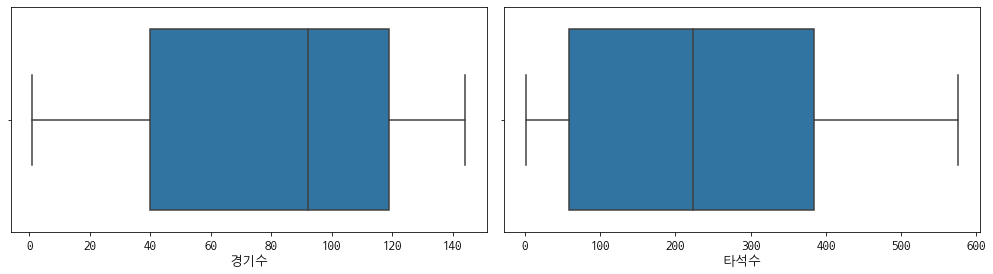

In [22]:
# 분포도 확인을 위해 박스플롯 출력
plt.subplot(121)
sns.boxplot(kbo['경기수'])

plt.subplot(122)
sns.boxplot(kbo['타석수'])

plt.tight_layout()

In [23]:
print(kbo['경기수'].describe())
print('--')
print(kbo['타석수'].describe())

count    1899.000000
mean       79.925224
std        43.881867
min         1.000000
25%        40.000000
50%        92.000000
75%       119.000000
max       144.000000
Name: 경기수, dtype: float64
--
count    1899.000000
mean      230.149552
std       170.080167
min         1.000000
25%        59.000000
50%       223.000000
75%       384.000000
max       576.000000
Name: 타석수, dtype: float64


In [24]:
# 경기수, 타석수가 25분위 미만 기록들은 제거하자.
reg_kbo = kbo.drop(kbo[kbo['경기수'] < 40].index)
reg_kbo.drop(reg_kbo[reg_kbo['타석수'] < 59].index, inplace=True)
reg_kbo

,이름,나이,경기수,타수,타석수,득점,안타,2루타,3루타,홈런,...,1루타,FBP,타율,출루율,장타율,OPS,도루율,홈런율,소속팀,스타팅
1,백용환,25.0,47.0,86.0,79.0,8.0,14.0,2.0,0.0,4.0,...,8.0,5.0,0.177,0.226,0.354,0.580,0.000,0.051,기타,False
2,백용환,26.0,65.0,177.0,154.0,22.0,36.0,6.0,0.0,10.0,...,20.0,20.0,0.234,0.316,0.468,0.784,0.750,0.065,기타,False
3,백용환,27.0,80.0,199.0,174.0,12.0,34.0,7.0,0.0,4.0,...,23.0,20.0,0.195,0.276,0.305,0.581,0.667,0.023,기타,False
8,김민식,27.0,88.0,170.0,144.0,17.0,37.0,9.0,0.0,2.0,...,26.0,23.0,0.257,0.359,0.361,0.720,0.500,0.014,기타,False
9,김민식,28.0,137.0,392.0,352.0,39.0,78.0,9.0,2.0,4.0,...,63.0,31.0,0.222,0.283,0.293,0.576,0.500,0.011,기타,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1907,이원석,31.0,121.0,459.0,411.0,55.0,109.0,20.0,1.0,18.0,...,70.0,38.0,0.265,0.323,0.450,0.773,1.000,0.044,기타,False
1908,이원석,32.0,128.0,543.0,479.0,74.0,144.0,30.0,1.0,20.0,...,93.0,59.0,0.301,0.374,0.493,0.867,0.667,0.042,기타,False
1909,조용호,28.0,68.0,225.0,191.0,34.0,52.0,7.0,1.0,0.0,...,44.0,28.0,0.272,0.365,0.319,0.684,0.846,0.000,기타,False
1911,히메네스,27.0,70.0,299.0,279.0,37.0,87.0,17.0,2.0,11.0,...,57.0,16.0,0.312,0.344,0.505,0.849,0.800,0.039,기타,False


### 8. 타율/출루율/장타율/홈런율/도루율/WAR/OPS 시즌기준 백분율 정규화
* 1995년 성적과 2002년 성적을 단순 1:1 비교는 곤란할 것 같다.
    * 스포츠 과학도 발전함에 따라 피지컬이나 훈련방식도 달라 경기력도 발전한다.
    * 공 반발계수도 당시 기록에 영향을 주기도 한다.
* 그렇다면 각 시즌 최고 지표를 100으로 하는 백분율로 환산하여, 시즌간 기록을 상대평가가 가능하도록 해보자.

In [25]:
# 기존 데이터에서 아래 컬럼들은 시즌 내 최고점을 기준으로 백분율 환산한다.
columns = ['타율', '출루율', '장타율', '도루율', '홈런율', 'WAR', 'OPS']

for year in range(reg_kbo['시즌'].min(), reg_kbo['시즌'].max()+1):
    year_df = reg_kbo[reg_kbo['시즌'] == year]
    
    max_data = {col: year_df[col].max() for col in columns}

    for index, row in year_df.iterrows():
        for col in columns:
            reg_kbo.at[index, col] = round(row[col] / max_data[col] * 100, 2)

reg_kbo.reset_index(inplace=True, drop=True)
reg_kbo[['이름', *columns]]

,이름,타율,출루율,장타율,도루율,홈런율,WAR,OPS
0,백용환,47.84,48.81,51.45,0.0,45.13,-5.57,51.83
1,백용환,61.42,63.58,59.24,75.0,65.00,7.20,60.92
2,백용환,51.86,58.11,46.85,66.7,24.21,-5.09,52.11
3,김민식,68.35,75.58,55.45,50.0,14.74,9.16,64.57
4,김민식,60.00,62.89,42.84,50.0,10.28,-6.07,51.85
...,...,...,...,...,...,...,...,...
1370,이원석,71.62,71.78,65.79,100.0,41.12,14.95,69.58
1371,이원석,83.15,81.84,68.66,66.7,38.89,48.66,73.79
1372,조용호,73.51,81.11,46.64,84.6,0.00,2.92,61.57
1373,히메네스,81.89,69.22,63.92,80.0,39.00,21.75,65.97


## KBO 전반 선수 분석

### 포지션별 분포

In [26]:
list(sorted(kbo['포지션'].unique()))

['1루수', '2루수', '3루수', '우익수', '유격수', '좌익수', '중견수', '지명타자', '포수']

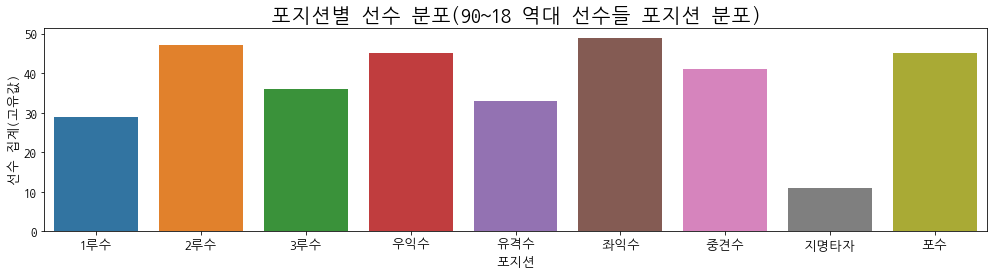

In [27]:
target = kbo.groupby(['이름']).max().sort_values('포지션').reset_index()

plt.title('포지션별 선수 분포(90~18 역대 선수들 포지션 분포)', size=20)
sns.countplot(x='포지션', data=target)
plt.ylabel('선수 집계(고유값)')

plt.tight_layout()

> 좌익수 출신들이 가장 많다.

### 포지션별 WAR/OPS 분석

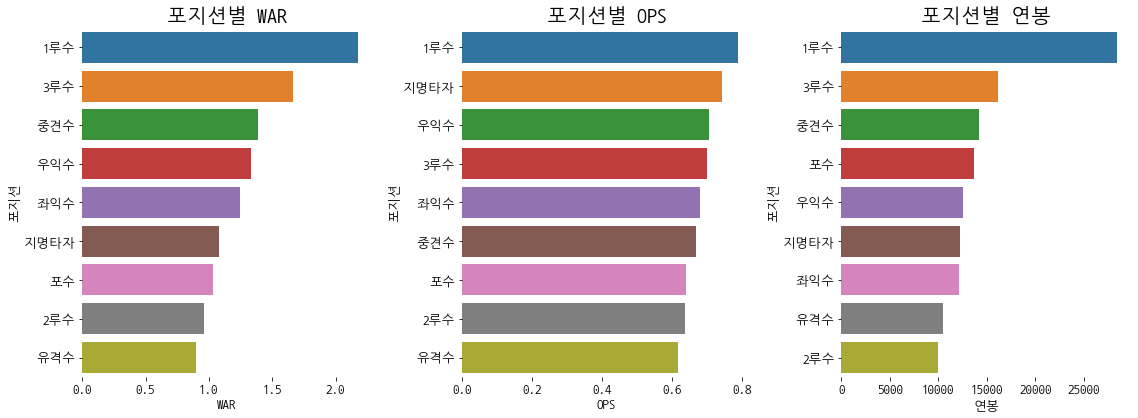

In [28]:
plt.figure(figsize=(16, 6))

# 포지션별 WAR
lr = kbo.groupby('포지션')['WAR'].mean().reset_index().sort_values('WAR', ascending=False)

ratio = lr['WAR']
labels = lr['포지션']

plt.subplot(131)
plt.title('포지션별 WAR', size=20)
sns.set_color_codes('pastel')
sns.barplot(x=ratio, y=labels)
sns.despine(left=True, bottom=True)

# 포지션별 OPS
lr = kbo.groupby('포지션')['OPS'].mean().reset_index().sort_values('OPS', ascending=False)

ratio = lr['OPS']
labels = lr['포지션']

plt.subplot(132)
plt.title('포지션별 OPS', size=20)
sns.set_color_codes('pastel')
sns.barplot(x=ratio, y=labels)
sns.despine(left=True, bottom=True)

# 포지션별 연봉
lr = kbo.groupby('포지션')['연봉'].mean().reset_index().sort_values('연봉', ascending=False)

ratio = lr['연봉']
labels = lr['포지션']

plt.subplot(133)
plt.title('포지션별 연봉', size=20)
sns.set_color_codes('pastel')
sns.barplot(x=ratio, y=labels)
sns.despine(left=True, bottom=True)

plt.tight_layout()

### 타석 위치별 분포

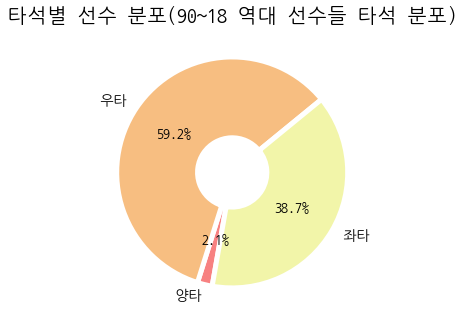

In [29]:
plt.figure(figsize=(6, 8))
colors = ['#F78181', '#F7BE81', '#F2F5A9']
wedgeprops = {'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}

target = kbo[['이름', '타석']].groupby(['이름']).max().reset_index()
target = target.groupby('타석').size().reset_index()

plt.title('타석별 선수 분포(90~18 역대 선수들 타석 분포)', size=20)
ratio = target[0]
labels = target['타석']
plt.pie(ratio, labels=labels, autopct='%.1f%%', startangle=260, counterclock=False, colors=colors, wedgeprops=wedgeprops, textprops={'fontsize': 14})

plt.tight_layout()

> 우타자들이 가장 많다.

## 좌타/우타/양타의 WAR/OPS 분석

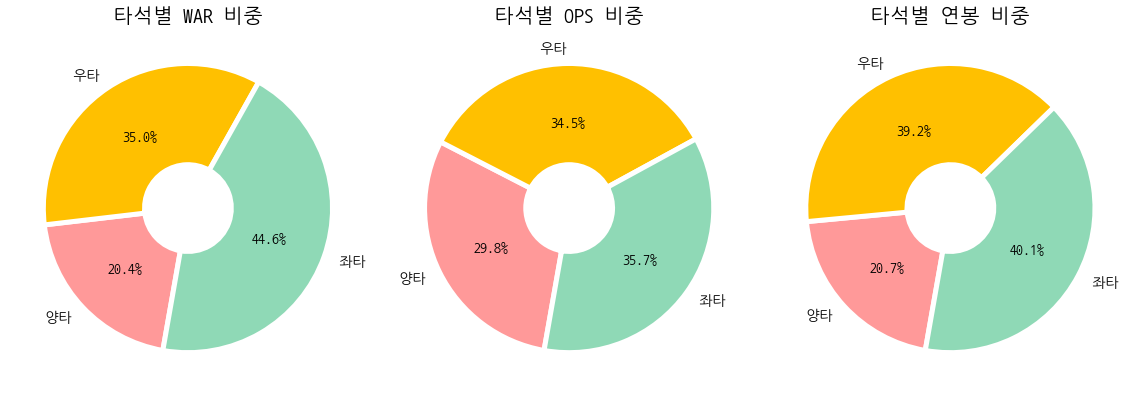

In [30]:
plt.figure(figsize=(16, 6))

colors = ['#ff9999', '#ffc000', '#8fd9b6']
wedgeprops = {'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}

# 타석 WAR
lr = kbo.groupby('타석')['WAR'].mean().reset_index().sort_values('WAR')

ratio = lr['WAR']
labels = lr['타석']

plt.subplot(131)
plt.title('타석별 WAR 비중', size=20)
plt.pie(ratio, labels=labels, autopct='%.1f%%', startangle=260, counterclock=False, colors=colors, wedgeprops=wedgeprops, textprops={'fontsize': 14})

# 타석 OPS
lr = kbo.groupby('타석')['OPS'].mean().reset_index().sort_values('OPS')

ratio = lr['OPS']
labels = lr['타석']

plt.subplot(132)
plt.title('타석별 OPS 비중', size=20)
plt.pie(ratio, labels=labels, autopct='%.1f%%', startangle=260, counterclock=False, colors=colors, wedgeprops=wedgeprops, textprops={'fontsize': 14})

# 타석 OPS
lr = kbo.groupby('타석')['연봉'].mean().reset_index().sort_values('연봉')

ratio = lr['연봉']
labels = lr['타석']

plt.subplot(133)
plt.title('타석별 연봉 비중', size=20)
plt.pie(ratio, labels=labels, autopct='%.1f%%', startangle=260, counterclock=False, colors=colors, wedgeprops=wedgeprops, textprops={'fontsize': 14})

plt.tight_layout()

> 타석위치도 WAR에 영향을 미친다. 좌타 > 우타 > 양타 순으로 기여도가 높다.
>
> 연봉/OPS도 좌타 > 우타 > 양타 순이다.
>
> 좌타자는 적은 수에 비해 승부에 주요한 자원인 듯 하다.

## 정규시즌 롯데순위 파악

In [31]:
saved_file = root_path + 'kbo_rank.csv'

if os.path.exists(saved_file):
    with open(saved_file, 'r') as f:
        kbo_rank = json.loads(f.read())
else:
    team = '롯데'
    kbo_rank = []
    for year in tqdm(range(kbo['시즌'].min(), kbo['시즌'].max()+1)):
        y_ranking = get_ranking(year)
        ranking = 10
        if team in y_ranking:
            ranking = y_ranking.index(team) + 1
        kbo_rank.append(dict(year=year, ranking=ranking))

    with open(saved_file, 'w') as f:
        f.write(json.dumps(kbo_rank))

rank_df = pd.DataFrame(kbo_rank)
rank_df

,year,ranking
0,1990,6
1,1991,4
2,1992,3
3,1993,6
4,1994,6
5,1995,3
6,1996,5
7,1997,8
8,1998,8
9,1999,10


In [32]:
# 플레이오프 성적기록. 수기로 임의 수집

kosi_ = {
    1992: 1,
    1995: 2,
    # 1999: 2  # 99년 무효
    2008: 3,
    2009: 4,
    2010: 4,
    2011: 3,
    2012: 4,
    2017: 3,
}

kosi = [dict(year=year, ranking=rank) for year, rank in kosi_.items()]
kosi_df = pd.DataFrame(kosi)
kosi_df

,year,ranking
0,1992,1
1,1995,2
2,2008,3
3,2009,4
4,2010,4
5,2011,3
6,2012,4
7,2017,3


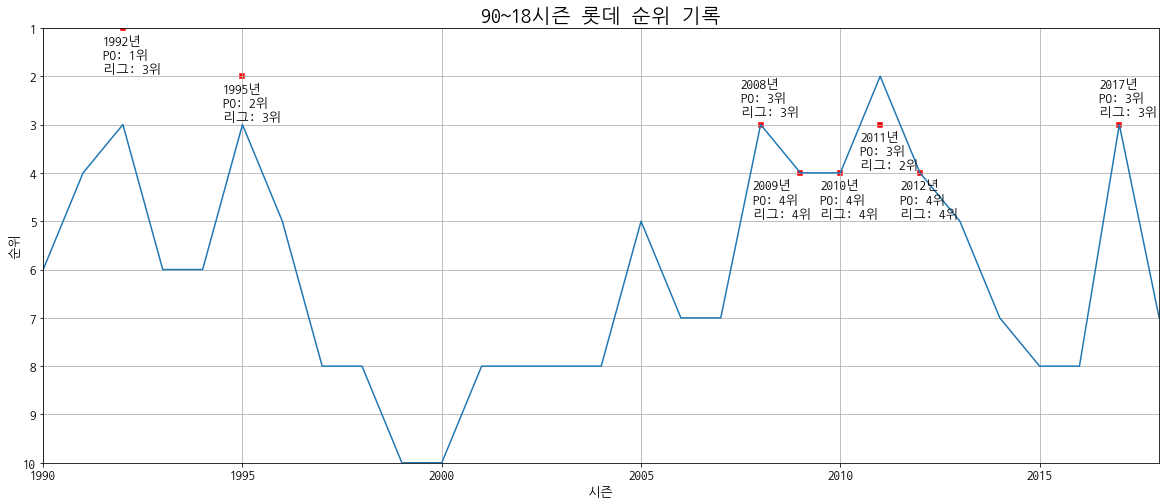

In [33]:
# 선그래프로 명확하게 확인
plt.figure(figsize=(20, 8))
plt.title('90~18시즌 롯데 순위 기록', size=20)
sns.lineplot(data=rank_df, x='year', y='ranking')
sns.scatterplot(data=kosi_df, x='year', y='ranking', marker='s', color='red')
plt.ylim([1, 10])
plt.xlim([1990, 2018])
plt.grid()
plt.gca().invert_yaxis() # 1위가 위로 오도록 y축 반전
plt.xlabel('시즌')
plt.ylabel('순위')

# 플레이오프 기록 텍스트 표기
upper = [2008, 2017]
for idx, row in rank_df.iterrows():
    df = kosi_df[kosi_df['year'] == row['year']].reset_index(drop=True)
    if len(df):
        a = df.iloc[0]['ranking']
        b = row['ranking']
        y = df.iloc[0]['year']
        gap = [0.5, 0.9]
        if y == 2009:
            gap[0] = 1.2
        if y in upper:
            gap[1] -= 1.1
        plt.text(y-gap[0], df.iloc[0]['ranking']+gap[1], f'{y}년\nPO: {a}위\n리그: {b}위')

plt.show()

> 정규리그에서 1위 한 적이 없다..
>
> 92년에 한국시리즈 우승이 최고 좋은 기록이다.
>
> 1999년, 2000년은 10위로 표기되는데, 당시 단일리그가 아닌 2개리그로 나누어 운영되었기에 순위를 표기할 수 없음.

## 역대 시즌별 롯데의 WAR/OPS/연봉 평균 분석

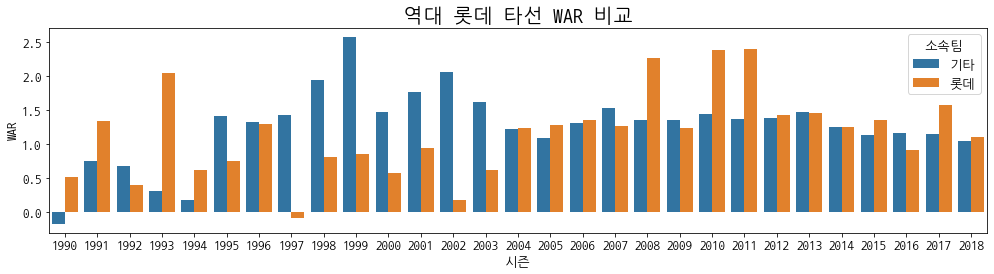

In [34]:
# WAR 비교
target = kbo.groupby(['시즌', '소속팀']).mean().reset_index()[['시즌', '소속팀', 'WAR']]

plt.title('역대 롯데 타선 WAR 비교', size=20)
sns.barplot(x='시즌', y='WAR', hue='소속팀', data=target)

plt.tight_layout()

> 90년대 초반엔 괴물같은 팀이었다. 92년 KS 우승, 95년 PO 2위 성적이 괜히 나온건 아닌 것 같다.
>
> 플레이오프 진출시즌과 비슷하게 맞물려 퍼포먼스를 보여준다.

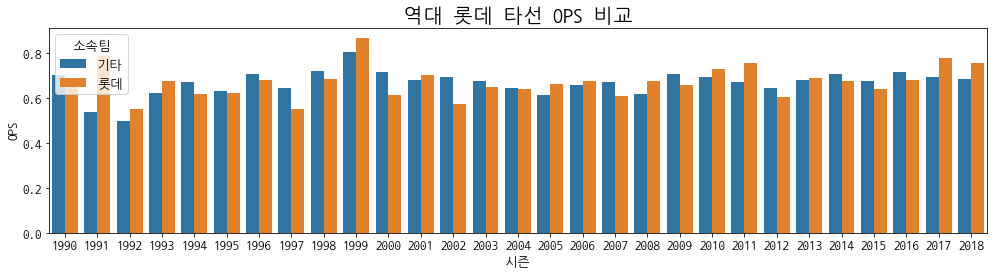

In [35]:
# OPS 비교
target = kbo.groupby(['시즌', '소속팀']).mean().reset_index()[['시즌', '소속팀', 'OPS']]

plt.title('역대 롯데 타선 OPS 비교', size=20)
sns.barplot(x='시즌', y='OPS', hue='소속팀', data=target)

plt.tight_layout()

> OPS는 타팀과 크게 다르진 않다.

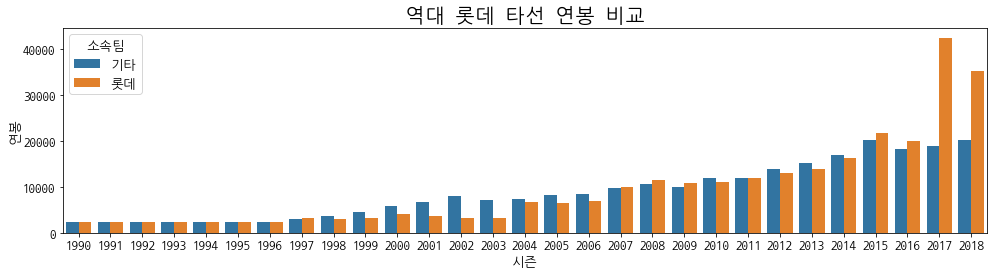

In [36]:
# 연봉 비교
target = kbo.groupby(['시즌', '소속팀']).mean().reset_index()[['시즌', '소속팀', '연봉']]

plt.title('역대 롯데 타선 연봉 비교', size=20)
sns.barplot(x='시즌', y='연봉', hue='소속팀', data=target)

plt.tight_layout()

> 17, 18년에 상당히 공격적인 투자를 진행했다.

## 스탯 분석 시작

## 역대 시즌 종합 스탯 비교

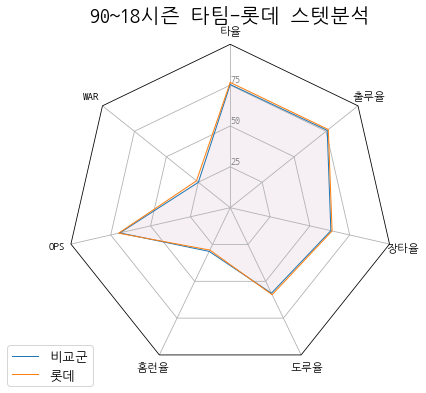

In [37]:
data1 = reg_kbo[reg_kbo['소속팀'] != '롯데']
data2 = reg_kbo[reg_kbo['소속팀'] == '롯데']

plt.figure(figsize=(6, 6))
render_spider_plot(data1, data2, title='90~18시즌 타팀-롯데 스텟분석')
plt.tight_layout()

> 특징적으로 특출난 부분이 없다.. 평균만큼 하니까 우승을 못하나보다

## 16~18시즌 스탯 종합 비교

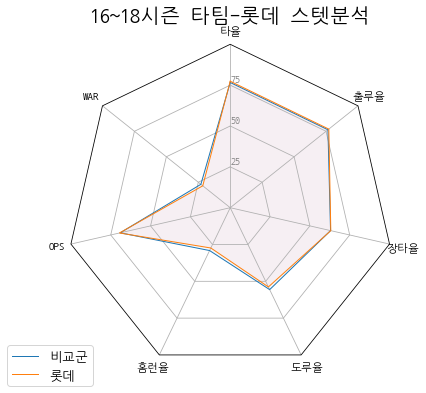

In [38]:
data1 = reg_kbo[(reg_kbo['소속팀'] != '롯데') & (reg_kbo['시즌'] >= 2016)]
data2 = reg_kbo[(reg_kbo['소속팀'] == '롯데') & (reg_kbo['시즌'] >= 2016)]

plt.figure(figsize=(6, 6))
render_spider_plot(data1, data2, title='16~18시즌 타팀-롯데 스텟분석')
plt.tight_layout()

## 2011년 롯데 스탯분석
* 과거 30년간 2011년(2위) 성적이 가장 좋았다.
* 특출난 부분이 있었는지 확인해보자.

### 1. 타팀과 롯데를 비교

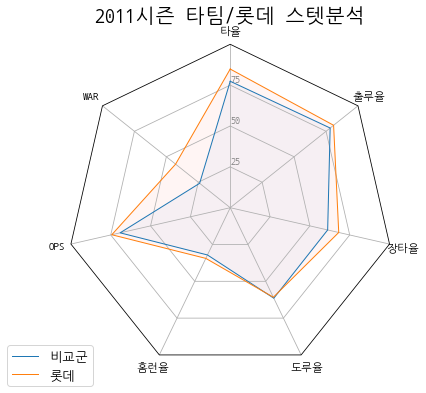

In [39]:
data1 = reg_kbo[(reg_kbo['시즌'] == 2011) & (reg_kbo['소속팀'] != '롯데')]
data2 = reg_kbo[(reg_kbo['시즌'] == 2011) & (reg_kbo['소속팀'] == '롯데')]

plt.figure(figsize=(6, 6))
render_spider_plot(data1, data2, title='2011시즌 타팀/롯데 스텟분석')
plt.tight_layout()

> 도루를 제외하고 모든 스탯이 높다. 타율/장타율, 특히 WAR가 높은걸 확인할 수 있다.

### 2. 2011 우승팀과 비교

In [40]:
rank_2011 = get_ranking(2011)
{idx+1: team for idx, team in enumerate(rank_2011)}

{1: '삼성', 2: '롯데', 3: 'SK', 4: 'KIA', 5: '두산', 6: 'LG', 7: '한화', 8: '넥센'}

> 삼성이 2011 우승팀이다.

#### 2-1) 삼성팀 데이터 크롤링

In [41]:
team = '삼성'

y_starting = get_starting(2011, team)
y_players = list(set(get_players(2011, team) + y_starting))

print(', '.join(sorted(y_players)))

가코, 강명구, 강봉규, 곽동현, 곽동훈, 구자운, 권오원, 권오준, 권혁, 김건필, 김경모, 김기태, 김동명, 김동영, 김상수, 김선민, 김성래, 김성훈, 김용국, 김재걸, 김재우, 김정혁, 김종호, 김종화, 김종훈, 김지훈, 김태욱, 김태한, 김평호, 김한수, 김헌곤, 김현욱, 김형준, 김호, 김효남, 류중일, 매티스, 명재철, 모상기, 문선엽, 문현정, 박민규, 박석민, 박한이, 박화랑, 배영섭, 배영수, 백정현, 성준, 손상득, 손주인, 신명철, 신희섭, 심창민, 안지만, 양일환, 오승환, 오정복, 오태선, 원종선, 유원선, 윤성환, 윤영삼, 이강혁, 이경록, 이규대, 이동걸, 이영욱, 이우선, 이정식, 임익준, 임진우, 임현준, 장원삼, 장태수, 장효조, 저마노, 전진형, 정명현, 정민우, 정우양, 정인욱, 정현욱, 정형식, 정회열, 조동찬, 조영훈, 조원태, 진갑용, 차우찬, 채상병, 채태인, 최형우, 추승민, 카도쿠라, 현재윤, 황수범


#### 2-2) 삼성 선수들 소속팀 기록

In [42]:
for index, row in reg_kbo[(reg_kbo['시즌']==2011) & (reg_kbo['이름'].isin(y_players))].iterrows():
    reg_kbo.at[index, '소속팀'] = '삼성'
    if reg_kbo.loc[index]['이름'] in y_starting:
        reg_kbo.at[index, '스타팅'] = True

#### 2-3) 삼성/롯데 스탯 비교

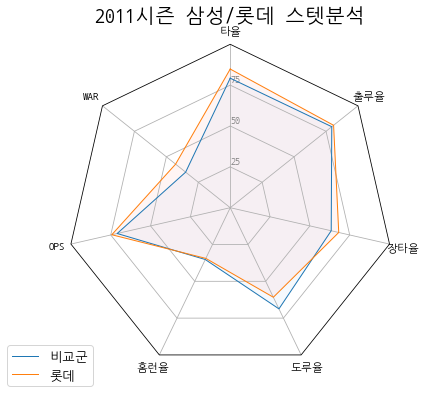

In [43]:
data1 = reg_kbo[(reg_kbo['시즌'] == 2011) & (reg_kbo['소속팀'] == '삼성')]
data2 = reg_kbo[(reg_kbo['시즌'] == 2011) & (reg_kbo['소속팀'] == '롯데')]

plt.figure(figsize=(6, 6))
render_spider_plot(data1, data2, title='2011시즌 삼성/롯데 스텟분석')
plt.tight_layout()

> 롯데가 모든 스탯에서 근소하게 앞선다. 삼성은 도루에서 앞서는데, 기막힌 도루작전으로 승점을 많이 딴 듯 하다.

In [44]:
target = reg_kbo[(reg_kbo['시즌'] == 2011) & (reg_kbo['소속팀'] != '기타')][['이름', '소속팀', '도루성공', '도루실패', '도루율']].sort_values(['도루율'], ascending=False)
target

,이름,소속팀,도루성공,도루실패,도루율
752,진갑용,삼성,1.0,0.0,100.0
944,채태인,삼성,1.0,0.0,100.0
1162,김상수,삼성,29.0,7.0,80.6
305,배영섭,삼성,33.0,8.0,80.5
989,손아섭,롯데,13.0,4.0,76.5
619,박석민,삼성,3.0,1.0,75.0
968,전준우,롯데,23.0,9.0,71.9
30,김주찬,롯데,25.0,10.0,71.4
1015,문규현,롯데,5.0,2.0,71.4
670,황재균,롯데,12.0,6.0,66.7


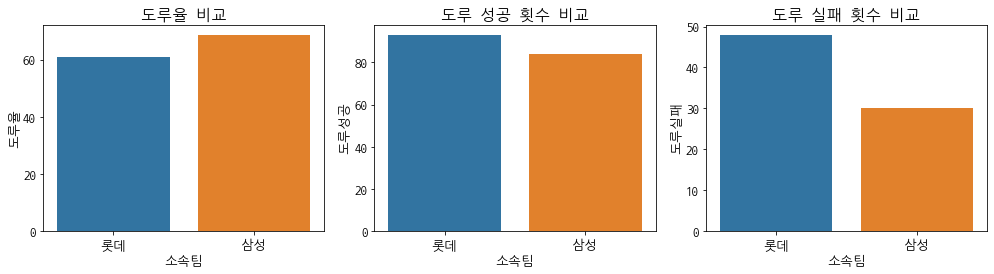

In [45]:
# 롯데/삼성 도루율, 도루성공, 도루실패 비교
ax = plt.subplot(131)
ax.set_title('도루율 비교')
target2 = target.groupby('소속팀').mean().reset_index()
target2
sns.barplot(x='소속팀', y='도루율', data=target2)

ax = plt.subplot(132)
ax.set_title('도루 성공 횟수 비교')
target2 = target.groupby('소속팀').sum().reset_index()
target2
sns.barplot(x='소속팀', y='도루성공', data=target2)

ax = plt.subplot(133)
ax.set_title('도루 실패 횟수 비교')
target2 = target.groupby('소속팀').sum().reset_index()
target2
sns.barplot(x='소속팀', y='도루실패', data=target2)

plt.tight_layout()

> 확실히 삼성의 도루 성공율이 높다

## 2015년 롯데 스텟분석
* 2011년 2위 기록 후 2015년 까지 점점 내려가 8위까지 내려갔다.
* 진짜 질 만 했는지 궁금하다.

### 1. 타팀과 롯데 스탯비교

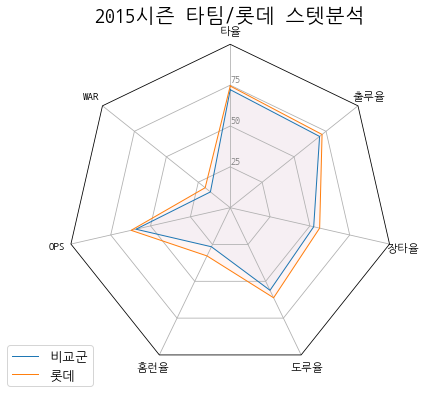

In [46]:
data1 = reg_kbo[(reg_kbo['시즌'] == 2015) & (reg_kbo['소속팀'] != '롯데')]
data2 = reg_kbo[(reg_kbo['시즌'] == 2015) & (reg_kbo['소속팀'] == '롯데')]

plt.figure(figsize=(6, 6))
render_spider_plot(data1, data2, title='2015시즌 타팀/롯데 스텟분석')
plt.tight_layout()

> 타팀 평균 대비 모든 스탯이 밀리진 않는다. 정신력이 문제였던걸까 감독이 문제였던걸까..

### 2. 2015 우승팀과 비교

In [47]:
rank_2015 = get_ranking(2015)
{idx+1: team for idx, team in enumerate(rank_2015)}

{1: '삼성',
 2: 'NC',
 3: '두산',
 4: '넥센',
 5: 'SK',
 6: '한화',
 7: 'KIA',
 8: '롯데',
 9: 'LG',
 10: 'kt'}

> 2015년 우승팀 역시 삼성이다.

#### 2-1) 삼성 선수자료 크롤링

In [48]:
team = '삼성'

y_starting = get_starting(2015, team)
y_players = list(set(get_players(2015, team) + y_starting))

print(', '.join(sorted(y_players)))

강봉규, 구자욱, 권오준, 김건한, 김기태, 김기환, 김대우, 김상수, 김성표, 김성한, 김응민, 김재우, 김재현, 김정혁, 김태완, 김현우, 김희석, 나바로, 나성용, 노진용, 문선엽, 박계범, 박근홍, 박민규, 박석민, 박제윤, 박찬도, 박한이, 박해민, 배영섭, 백상원, 백정현, 서동환, 신용운, 심창민, 안지만, 우동균, 윤대경, 윤성환, 윤영수, 이상훈, 이승엽, 이영욱, 이영욱9, 이정식, 이지영, 이흥련, 임창용, 임현준, 장원삼, 장필준, 정광운, 정민우, 정인욱, 조현근, 진갑용, 차우찬, 차화준, 최민구, 최선호, 최형우, 클로이드, 피가로


#### 2-2) 삼성선수 소속팀 기록

In [49]:
for index, row in reg_kbo[(reg_kbo['시즌'] == 2015) & (reg_kbo['이름'].isin(y_players))].iterrows():
    reg_kbo.at[index, '소속팀'] = '삼성'
    reg_kbo.at[index, '스타팅'] = row['이름'] in y_starting

#### 2-3) 삼성과 롯데 스탯비교

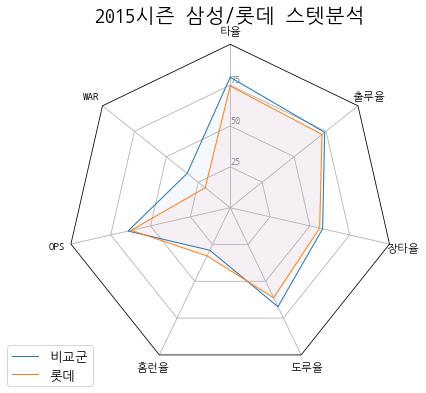

In [50]:
data1 = reg_kbo[(reg_kbo['시즌'] == 2015) & (reg_kbo['소속팀'] == '삼성')]
data2 = reg_kbo[(reg_kbo['시즌'] == 2015) & (reg_kbo['소속팀'] == '롯데')]

plt.figure(figsize=(6, 6))
render_spider_plot(data1, data2, title='2015시즌 삼성/롯데 스텟분석')
plt.tight_layout()

> 삼성과 비교했을 때, 수치들이 밀리긴 하지만 1위와 8위의 차이라고 하기엔 다소 억울해보인다.
>
> 특히 OPS는 크게 차이나지 않는데, WAR에서 벌어진다. 홈런율도 근소하게 높은것으로 보아, 전반적인 타선은 좋았으나 주루 작전이 좋지 못했던걸까? 더 확실한 근거가 필요할 것 같다.
>
> 아쉽지만 투수와 수비 데이터는 처음에 제공되지 않아 외부페이지를 참고했다.

* 2015년 시즌결과 페이지(http://www.statiz.co.kr/league.php?opt=2015&sopt=0) 의 WAA 테이블에서 삼성-롯데를 비교해보면

    1. 타격은 삼성(10.47) / 롯데(1.39)
    2. 주루는 삼성(0.94) / 롯데(-2.29)
    3. 수비는 삼성(6.13) / 롯데(0.58)
    4. 선발은 삼성(-3.11) / 롯데(1.15)
    5. 구원은 삼성(0.16) / 롯데(-4.04) 를 기록했다.

* 종합해보면, 선발투수가 그나마 선방했지만 시즌 최고기록(LG, 3.6)에 비해 낮은 수치이고, 공/수는 터무니 없었으며 마무리 투수도 제몫을 하지 못한 것으로 보인다.

## 포지션별 스탯분석

### 1. 포지션별 타팀/롯데 스탯비교

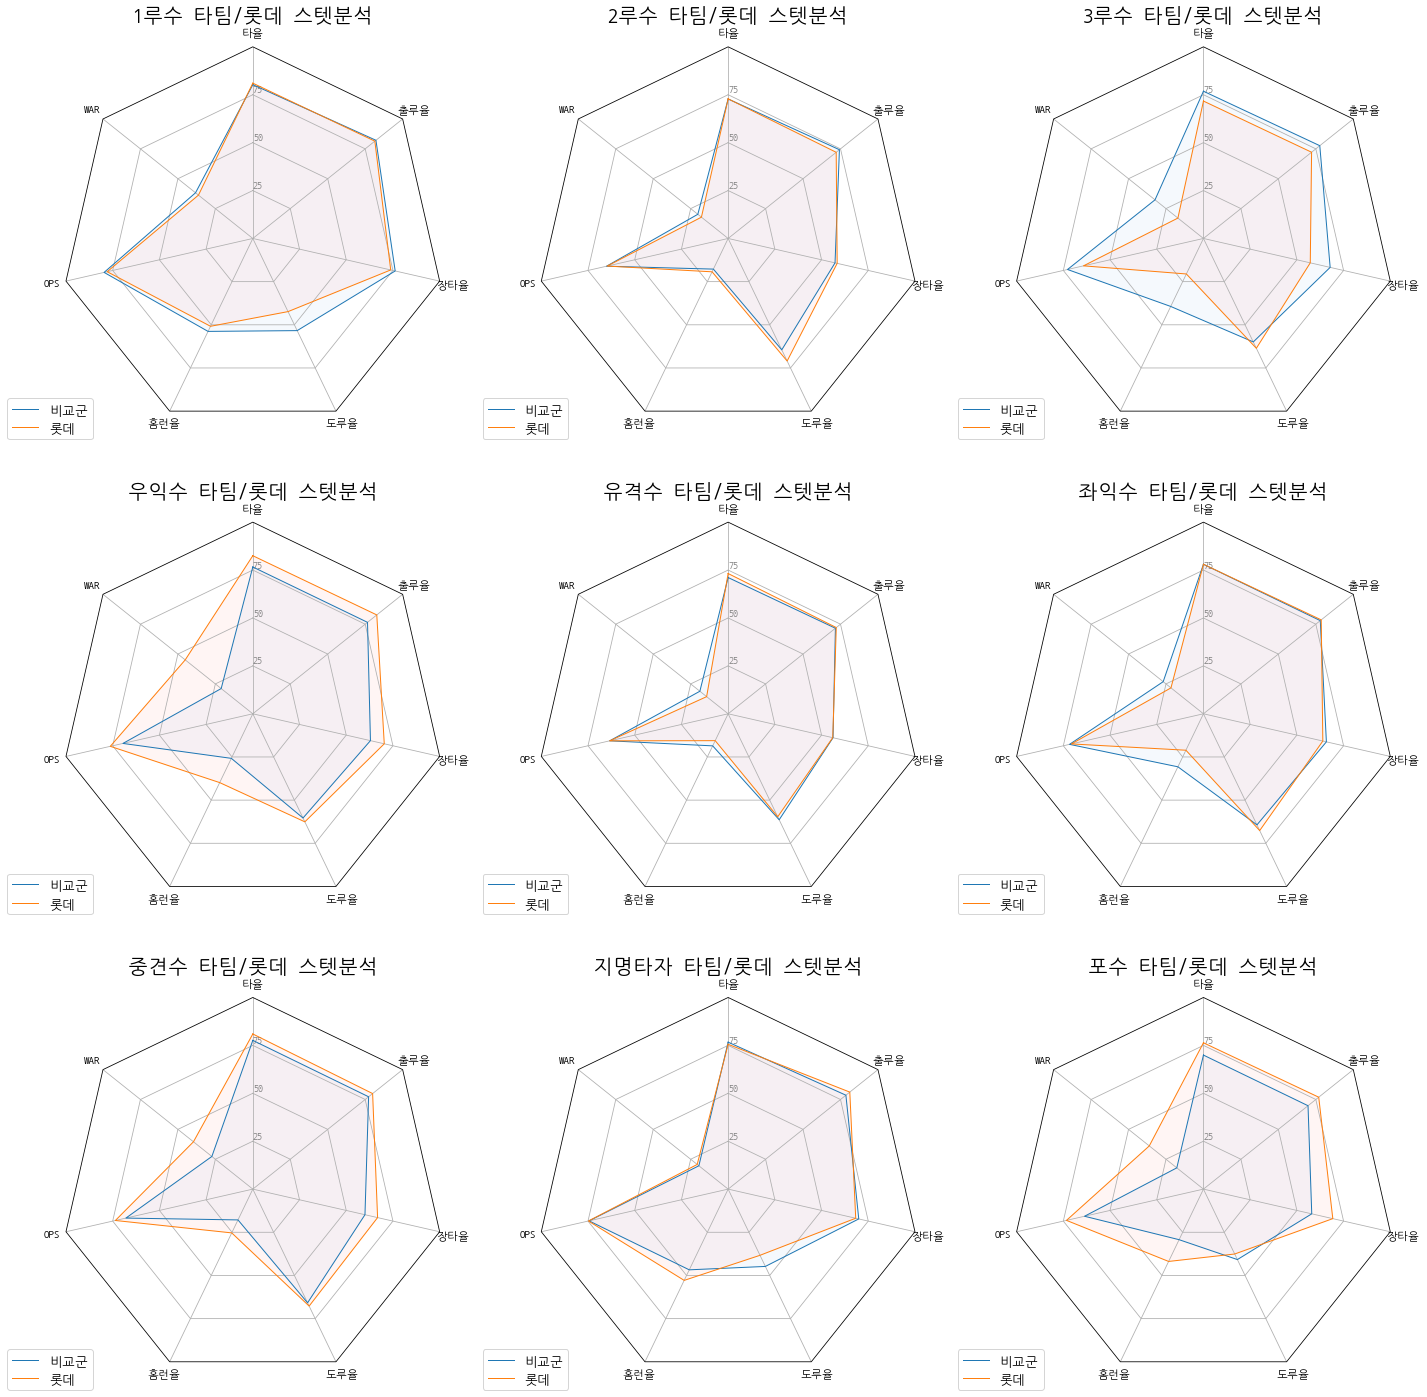

In [51]:
position = list(sorted(reg_kbo['포지션'].unique()))

plt.figure(figsize=(20, 20))
for idx, pos in enumerate(position):
    data1 = reg_kbo[(reg_kbo['포지션'] == pos) & (reg_kbo['소속팀'] != '롯데')]
    data2 = reg_kbo[(reg_kbo['포지션'] == pos) & (reg_kbo['소속팀'] == '롯데')]
    ax = plt.subplot(330 + idx + 1, polar=True)
    render_spider_plot(data1, data2, title=f'{pos} 타팀/롯데 스텟분석', ax=ax)

plt.tight_layout()

> 롯데의 포지션 별 스탯을 비교해보니 우익수, 중견수, 포수 포지션에 좋은 선수들을 보유했던 것 같다.

### 2. WAR 기준 포지션 별 TOP 10과 기타 선수들을 비교

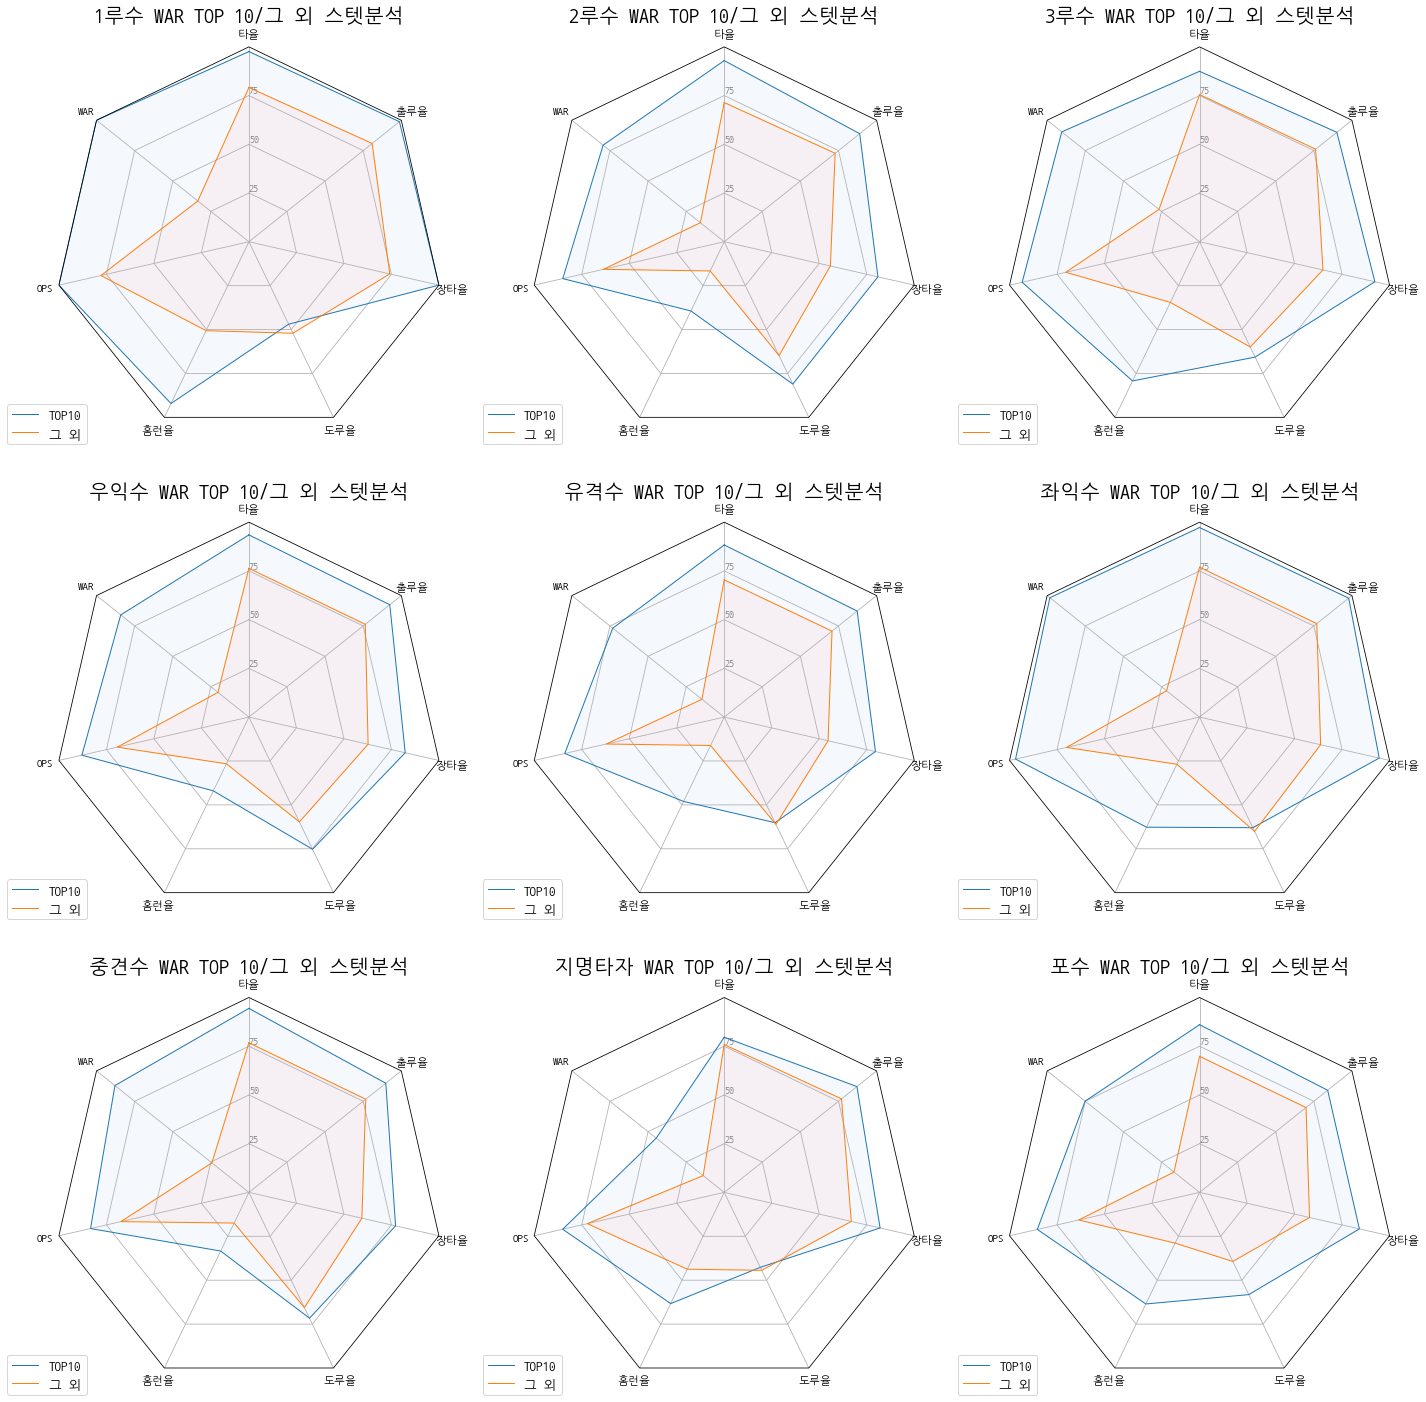

In [52]:
position = list(sorted(reg_kbo['포지션'].unique()))

plt.figure(figsize=(20, 20))
for idx, pos in enumerate(position):
    top_war = reg_kbo[reg_kbo['포지션'] == pos].sort_values(['WAR'], ascending=False)
    data1 = top_war[:10]  # TOP 10
    data2 = top_war[10:]  # 그 외
    ax = plt.subplot(330 + idx + 1, polar=True)
    render_spider_plot(data1, data2, title=f'{pos} WAR TOP 10/그 외 스텟분석', ax=ax, label=['TOP10', '그 외'])

plt.tight_layout()

> 확실히 WAR Top 10 선수들 스탯이 월등하다.

## 정리
* 타자들의 스탯만으론 우승을 결정할 수 없다.
    * 투수와 수비력이 뒷받침 되어야 완벽한 팀이 된다.
    * 위 데이터가 분석에 포함되지 못해 아쉽다.
    * 타순 데이터가 제공되었으면 분석이 더 용이했을 것 같다. 타순 구성도 경기운영에 주요한데, 포지션 만으론 타순을 예측하기 힘들다.
* 포지션별 스탯을 확인해보면
    * 1루수는 대체로 홈런타자가 위치한다. 3루수도 거포형 타자들이 위치한다. 공통적으로 발이 느리기도 하다.
    * 2루수, 외야 포지션엔 발이 빠른(도루율) 선수들이 위치한다.
    * 지명타자는 발이 느리더라도 확실한 안타로 연결짓는 능력이 주요해 보인다.
    * 포수는 공만 받는것이 아니라 타선에서의 능력도 함께 필요로 한다.
* 좌타자가 대체로 승리 기여도가 높다.
* 롯데는 언제쯤 우승할까?